# Training Meta-Value vs itself/naive/LOLA

# Imports

In [ ]:
import dataclasses, pickle, os, sys, time
import subprocess as sp
from functools import partial
import itertools,functools
from pathlib import Path
import numpy as np
import jax, jax.numpy as jp, jax.random as rax, jax.tree_util as tu
import flax, flax.linen as nn, flax.serialization, flax.struct as struct
import matplotlib.pyplot as plt
import tabulate

stop = jax.lax.stop_gradient
deepmap = tu.tree_map

# Utilities

In [ ]:
def eqzip(*xss):
  xss = list(map(list, xss))
  assert all(len(xs) == len(xss[0]) for xs in xss)
  return list(map(list, zip(*xss)))
def unzip2(xss):
  if not xss: return [], []
  return eqzip(*xss)
def rscope(rng, *path):  # rax.fold_in arbitrary information
  import zlib
  data = "/".join(map(str, path)).encode("ascii")
  seed = zlib.crc32(data)
  return rax.fold_in(rng, seed)
def params_rscope(rng, params):
  return map_nested_dict(lambda path, param: rscope(rng, "/".join(map(str, path))),
                         params)

def quantile_regression_loss(q, x):
  [Q]=q.shape; [N]=x.shape
  if Q == 1:  # do simple regression loss if single quantile
    return huber(q-x).mean()
  deltas = x[None,:]-q[:,None]
  tau = (jp.arange(Q)[:,None]+0.5)/Q  # quantile midpoints
  loss = jp.abs(tau-(deltas<0)) * huber(deltas)
  return loss.sum()/N

def huber(delta, threshold=1):
  delta = jp.abs(delta)
  return jp.where(delta <= threshold,
                  delta**2/2,
                  threshold*delta-threshold**2/2)

def moving_avg(xs, k, axis):
  return np.lib.stride_tricks.sliding_window_view(xs,k,axis=axis).mean(axis=-1)

def value_and_naive_gradients(f):
  def fn(agents):
    y, df = jax.vjp(f, agents)
    [dydx] = jax.vmap(df)(jp.eye(2,dtype="float32"))
    dx = jp.einsum("ii...->i...", dydx)
    return y, dx
  return fn
def naive_gradients(f):
  def fn(agents):
    y, dx = value_and_naive_gradients(f)(agents)
    return dx
  return fn

from collections import abc
def iterate_nested_dict(node):
  if not isinstance(node, abc.Mapping):
    yield (), node
  else:
    for key, child in node.items():
      for path, leaf in iterate_nested_dict(child):
        yield (key, *path), leaf
def map_nested_dict(fn, node, path=()):
  if not isinstance(node, abc.Mapping):
    return fn(path, node)
  return {
    key: map_nested_dict(fn, child, (*path, key))
    for key, child in node.items()
  }
def map_params_dict(fn, node):
  return flax.core.freeze(map_nested_dict(fn, node))

def deepstack(xs, axis=0):
  return deepmap(lambda *xs: jp.stack(xs,axis=axis), *xs)
def deepunstack(xs, axis=0):
  import operator
  [n] = np.unique([x.shape[axis] for x in tu.tree_leaves(xs)])
  def make_itemgetter(i):  # makes a lambda x: x[:,...,:,i]
    return operator.itemgetter((*[slice(None) for _ in range(axis)],i))
  return [deepmap(make_itemgetter(i), xs) for i in range(n)]

In [ ]:
@struct.dataclass
class AdamOptimizer:
  lr: float = struct.field(pytree_node=False, default=1e-3)
  eps: float = struct.field(pytree_node=False, default=1e-8)
  beta1: float = struct.field(pytree_node=False, default=0.9)
  beta2: float = struct.field(pytree_node=False, default=0.99)
  clip: "Any" = struct.field(pytree_node=False, default=None)
  decay: float = struct.field(pytree_node=False, default=0.01)
  moment1: "Any" = None
  moment2: "Any" = None
  n: int = 0

  @classmethod
  def make_for(cls, params, **hp):
    moment1 = deepmap(jp.zeros_like, params)
    moment2 = deepmap(jp.zeros_like, params)
    return cls(moment1=moment1, moment2=moment2, n=jp.array(0, dtype="int32"), **hp)

  def __call__(self, params, grad):
    if self.clip is not None:
      grad = deepmap(lambda dx: jp.clip(dx, -self.clip, +self.clip), grad)
    moment1 = deepmap(lambda m,dx: m + (1-self.beta1)*(dx-m), self.moment1, grad)
    moment2 = deepmap(lambda m,dx: m + (1-self.beta2)*(dx**2-m), self.moment2, grad)
    n = self.n + 1
    dbmoment1 = deepmap(lambda m: m / (1-self.beta1**n), moment1)
    dbmoment2 = deepmap(lambda m: m / (1-self.beta2**n), moment2)
    step = deepmap(lambda dm1,dm2,x: (self.lr*(dm1/(self.eps+dm2**0.5))
                                      -jp.abs(self.lr)*self.decay*x),
                   dbmoment1, dbmoment2, params)
    new_self = self.replace(moment1=moment1, moment2=moment2, n=n)
    return new_self, step

def apply_grads(optimizers, modules, grads):
  optimizers, steps = unzip2(opt(m, grad) for opt, m, grad in eqzip(optimizers, modules, grads))
  new_modules = [deepmap(lambda x, dx: x + dx, module, step)
                 for module, step in eqzip(modules, steps)]
  return optimizers, new_modules

# Configuration

In [ ]:
# NOTE these are defaults -- they will be varied for ablation/tournament
@struct.dataclass
class Hp:
  game: str = "ipd"
  game_discount: float = 0.96
  opponent: str = "meva" # naive/lola/meva
  outer_lr: float = 1e-3
  alpha: float = 1
  outer_num_steps: int = 100
  inner_num_steps: int = 100
  stride: int = 10
  batch_size: int = 128
  rho: float = 0.99
  lamda: float = 0.9
  seed: int = 1
  predict_target: int = 1
  semigradient: int = 1
  explore_target: int = 0  # use target_vhat for exploration?
  explore_signs: int = 1  # flip signs on final layer for exploration?
  noisynet: int = 0  # use noisy networks?
  correction_version: int = 1  # agents follow grad(f+gamma V), V=f'+gamma V'
  fixed_gamma: float = None  # use fixed gamma throughout training
  quantiles: int = 64
  num_resblocks: int = 1

  def get_game(self):
    return Game(payoffs=PAYOFF_MATRICES[self.game],discount=self.game_discount)

  @classmethod
  def make_for_game(cls,game,**kwargs):
    hp = cls(game=game,**kwargs)
    # divide by 1-self.game_discount to match LOLA/M-FOS learning rates
    alpha = dict(ipd=1/(1-hp.game_discount),imp=1/(1-hp.game_discount),chicken=1)[hp.game]
    return hp.replace(alpha=alpha)

# Game definition

In [ ]:
PAYOFF_MATRICES = dict(
  ipd=np.array([[-2,0,-3,-1], [-2,-3,0,-1]]).T,  # [state, player]
  imp=np.array([[+1,-1,-1,+1], [-1,+1,+1,-1]]).T,
  chicken=np.array([[-100,+1,-1,0], [-100,-1,+1,0]]).T,
)

@struct.dataclass
class Game:
  payoffs: "Any"
  discount: float = 0.96

  @classmethod
  def make(cls, key, discount=0.96):
    return cls(PAYOFF_MATRICES[key], discount)
  def __call__(self,x):
    return self.call_aux(x)[0]
  def call_aux(self,x):
    pi = nn.sigmoid(x)
    assert pi.shape == (2,5)
    pi = pi.at[1].set(pi[1,(0,1,3,2,4)])  # swap player 2 perspective
    pi = jp.stack([1-pi,pi], axis=-1) # [player, state, action]
    p0 = jp.einsum("a,b->ab", pi[0,0], pi[1,0]).reshape([4]) # initial state distribution
    P = jp.einsum("sa,sb->sab", pi[0,1:], pi[1,1:]).reshape([4,4])  # transition matrix
    I = jp.eye(4)
    effective_state = (1-self.discount)*p0@jp.linalg.inv(I-self.discount*P)
    returns = effective_state@self.payoffs
    return returns, dict(returns=returns, effective_state=effective_state,
                         epstats=dict(zip("DD DC CD CC".split(), effective_state)))
  def vmap(self,x):
    assert x.shape[-2:] == (2,5)
    if x.shape == (2,5): return self(x)
    else: return jax.vmap(self.vmap)(x)

def init_agents(rng, batch_shape=()):
  return rax.normal(rng, shape=[*batch_shape,2,5])

def make_f_lola(game):
  f = game
  def f_lola_dice(x, alpha=1/(1-game.discount)):
    x_extra = x + alpha*naive_gradients(f)(x)
    return jp.stack([
        f(jp.stack([x[0], x_extra[1]]))[0],
        f(jp.stack([x_extra[0], x[1]]))[1],
    ])
  def f_lola_taylor(x, alpha=1/(1-game.discount)):
    dydx = jax.jacrev(f)(x)
    y_extra = jp.stack([
        stop(dydx[0][1])@dydx[1][1],
        stop(dydx[1][0])@dydx[0][0],
    ])
    return f(x) + alpha*y_extra
  return f_lola_taylor

def permute_game(f,i):
  def g(x):  # swap players if we are i==1
    x = x[((i,1-i),)]
    y = f(x)
    return y[((i,1-i),)]
  return g

# Architecture

In [ ]:
class VHatModule(nn.Module):
  hp: "Any" = None
  size: int = 128
  normalize: int = 1
  equivariant: int = 1
  quantiles: int = 64

  @nn.compact
  def __call__(self, agents, gamma, explore_rng=None, explore_level=0.):
    zpolicy = nn.sigmoid(agents)  # [player, features]
    zpolicy = nn.gelu(nn.Dense(self.size, name="embed")(zpolicy))
    zpolicy = nn.gelu(DenseNorm(self.size, normalize=self.normalize, name="zpolicy")(zpolicy))
    zgamma = nn.gelu(nn.Dense(self.size, name="zgamma")(gamma[:,None]))
    z = jp.concatenate([zpolicy, zgamma], axis=-1)

    if not self.equivariant:
      # players are following different learning algorithms, so we can't quite use
      # our equivariant parameterization. give the model a non-equivariant scale
      # and bias so it can distinguish the two players.
      z = (z * self.param("zscale", nn.initializers.ones, z.shape)
           + self.param("zbias", nn.initializers.zeros, z.shape))

    z = nn.gelu(DenseNorm(self.size, normalize=self.normalize, name="mix_gamma")(z))
    for layer in range(self.hp.num_resblocks):
      z = ResidualBlock(name=f"Q{layer}", normalize=self.normalize)(z)
    z = jp.concatenate([z, z[::-1]], axis=-1)
    z = nn.gelu(DenseNorm(self.size, normalize=self.normalize, name="mix_oppt")(z))
    for layer in range(self.hp.num_resblocks):
      z = ResidualBlock(name=f"R{layer}", normalize=self.normalize)(z)
    z = nn.tanh(DenseNorm(self.size, normalize=self.normalize, name="zfinal")(z))

    if self.hp.explore_signs and explore_rng is not None: # flip sign on units to vary vhat for use in explore
      mask = rax.bernoulli(rscope(explore_rng, "latent_mask"), p=1-explore_level, shape=z.shape)
      z = jp.where(mask, z, -z)  # [player, features]
    return nn.Dense(self.quantiles, name="output")(z) # [player, quantiles]

class DenseNorm(nn.Module):
  size: int
  normalize: int = 0

  @nn.compact
  def __call__(self, x):
    z = nn.Dense(self.size, kernel_init=nn.initializers.orthogonal(),
                 name="d", use_bias=not self.normalize)(x)
    if self.normalize:
      z = nn.LayerNorm(name="n")(z)
    return z

class ResidualBlock(nn.Module):
  normalize: int = 0

  @nn.compact
  def __call__(self, x):
    size = x.shape[-1]
    z = nn.gelu(DenseNorm(size, name="X", normalize=self.normalize)(x))
    y = nn.Dense(size, name=f"H")(z)
    gate = nn.sigmoid(self.param("G", nn.initializers.zeros, [z.shape[-1]]))
    return gate*x + (1-gate)*y

@struct.dataclass
class VHat:
  params: "Any"
  module: "Module" = struct.field(pytree_node=False)

  def __call__(self, agents, **kwargs):
    x = self.module.apply(dict(params=self.params), agents, **kwargs)
    return x.mean(axis=-1)

  def quantiles(self, agents, **kwargs):
    return self.module.apply(dict(params=self.params), agents, **kwargs)

  @classmethod
  def init(cls, module, rng):
    params = module.init(rng, init_agents(rax.PRNGKey(1)), gamma=jp.zeros([2], dtype="float32"))["params"]
    return cls(params, module)

  def rscope(self, rng):
    return self.replace(params=params_rscope(rng, self.params))
  def describe(self):  # show parameter shapes and sizes
    print("vhat params")
    for path, param in iterate_nested_dict(self.params):
      print("  ", "/".join(map(str, path)), param.shape, param.size)
    print("total vhat params", sum(param.size for param in tu.tree_leaves(self.params)))

# Training functions

In [ ]:
@struct.dataclass
class TrainState:
  step: int
  flat_step: int
  rng: "PRNGKey"
  vhat: "VHat"
  target_vhat: "VHat"
  optimizer: "AdamOptimizer"

  @classmethod
  def make(cls, hp):
    rng = rax.PRNGKey(hp.seed)
    equivariant = (hp.opponent=="meva" and hp.game!="imp")  # imp is not symmetric
    vhat = VHat.init(VHatModule(hp=hp, quantiles=hp.quantiles, equivariant=equivariant), rng=rscope(rng,"vhat"))
    target_vhat = VHat.init(VHatModule(hp=hp, quantiles=hp.quantiles, equivariant=equivariant), rng=rscope(rng,"tvhat"))
    if hp.noisynet:
      vhat = NoisyVHat.init(vhat)
      target_vhat = NoisyVHat.init(target_vhat)
    optimizer = AdamOptimizer.make_for(vhat, lr=-hp.outer_lr)
    return cls(step=jp.array(0), flat_step=jp.array(0), rng=rscope(rng, "train"),
               vhat=vhat, target_vhat=target_vhat, optimizer=optimizer)

  def pop_rng(self):
    rng, elt = rax.split(self.rng)
    return self.replace(rng=rng), elt

@struct.dataclass
class NoisyVHat:  # noisy net wrapper for VHat
  mean: "VHat"
  logscale: "VHat"

  def draw(self, rng):
    return deepmap(lambda mean,logscale,rng: mean+jp.exp(logscale)*rax.normal(rng,shape=mean.shape),
                   self.mean, self.logscale, self.mean.rscope(rng))
  @classmethod
  def init(cls, vhat):
    logscale_init = jp.log(1e-4)  # noisy nets paper suggests 0.017 but this works better
    logscale = deepmap(lambda x: logscale_init*jp.ones_like(x),vhat)
    return cls(mean=vhat,logscale=logscale)

# during training, we maintain "outer agents" -- agents that follow gradients of
# the model without any exploration and with fixed gamma. this allows us to
# monitor the performance while training.
#OAGENT_GAMMAS = {s: float(f"0.{s}") for s in "90 95 99".split()}
OAGENT_GAMMAS = {s: float(f"0.{s}") for s in "95".split()}

def train_meva(hp):
  game = hp.get_game()

  def draw_gamma(rng, shape=()):
    if hp.fixed_gamma is not None:
      return jp.full(shape, hp.fixed_gamma)
    return rax.beta(rng, 0.5, 0.5, shape=shape)  # arcsin distribution

  def prepare_vhat(vhat, gamma, context):
    vhat = partial(vhat, gamma=gamma)
    if not hp.correction_version: return vhat
    if context == "iagents": return vhat # just use vhat for explore
    def fn(x):
      y = game(x)
      vnext = vhat(x)
      return (1-gamma)*y+gamma*vnext
    return fn

  def extrapolate(x, vhat, rng, n):
    xs = [x]; auxes = []
    for i in range(n):
      f, episode = game.call_aux(x)
      grads = get_grads(vhat, x)
      x = x + hp.alpha * grads
      xs.append(x)
      auxes.append(dict(f=f, episode=episode, epstats=episode["epstats"]))
    f, episode = game.call_aux(x)
    auxes.append(dict(f=f, episode=episode, epstats=episode["epstats"]))
    return xs, auxes

  def get_grads(vhat, x):
    if hp.opponent == "naive":
      gradA = jax.grad(lambda x: vhat(x)[0])(x)[0]
      gradB = jax.grad(lambda x: game(x)[1])(x)[1]
      grads = jp.stack([gradA, gradB])
    elif hp.opponent == "lola":
      f_lola = make_f_lola(game)
      gradA = jax.grad(lambda x: vhat(x)[0])(x)[0]
      gradB = jax.grad(lambda x: f_lola(x,alpha=hp.alpha)[1])(x)[1]
      grads = jp.stack([gradA, gradB])
    elif hp.opponent == "meva":
      grads = naive_gradients(vhat)(x)
    return grads

  @partial(jax.jit, donate_argnums=(1,))
  def update_iagents(ostate, istate, rng, gamma, explore_rng):
    vhat = ostate.target_vhat if hp.explore_target else ostate.vhat
    explore_level = 1/16
    if hp.noisynet:
      vhat = vhat.draw(rscope(explore_rng,"noisynet"))
    @jax.vmap  # policy batch
    def fn(istate, rng, gamma, explore_rng):
      vhat_ = partial(vhat, explore_rng=explore_rng, explore_level=explore_level)
      vhat_ = prepare_vhat(vhat_, gamma, context="iagents")
      return extrapolate(istate, vhat_, rng, hp.stride)
    istates, epauxes = fn(istate, rax.split(rng, hp.batch_size),
                          gamma, rax.split(explore_rng, hp.batch_size))
    aux = dict(epstats=epauxes[0]["epstats"], f=epauxes[0]["f"])
    return istates[-1], aux

  @partial(jax.jit, donate_argnums=(0,))
  def update_vhat(ostate, istate, rng, gamma):
    if hp.noisynet:
      vhat,vhat_draw_vjp = jax.vjp(lambda vhat: vhat.draw(rscope(rng,"noisynet")), ostate.vhat)
      tvhat = ostate.target_vhat.draw(rscope(rng,"noisynet"))
    else:
      vhat = ostate.vhat; tvhat = ostate.target_vhat
    @jax.vmap  # policy batch
    def fn(istate, rng, gamma):
      vhat_ = prepare_vhat(vhat, gamma, context="vhat")
      istates, epauxes = extrapolate(istate, vhat_, rng, hp.stride)
      fs = [epaux["f"] for epaux in epauxes]
      return istates, epauxes, fs
    istates, epauxes, fs = fn(istate, rax.split(rscope(rng, "extrapolate"), hp.batch_size), gamma)
    loss_fn = get_loss_fn(tvhat, istates, fs, gamma)
    (loss, lossaux), grad = jax.value_and_grad(loss_fn, has_aux=True)(vhat)
    if hp.noisynet:
      [grad] = vhat_draw_vjp(grad)
    new_optimizer, dvhat = ostate.optimizer(ostate.vhat, grad)
    new_vhat = deepmap(lambda x,dx:x+dx, ostate.vhat, dvhat)
    new_target_vhat = deepmap(lambda xbar,x: xbar+(1-hp.rho)*(x-xbar), ostate.target_vhat, new_vhat)

    new_ostate = ostate.replace(optimizer=new_optimizer, vhat=new_vhat, target_vhat=new_target_vhat)
    aux = dict(epstats=epauxes[0]["epstats"], f=epauxes[0]["f"],
               loss=loss, td=lossaux["td"],
               gradnorms=deepmap(lambda x: (x**2).mean(), grad))
    return new_ostate, aux
  @jax.jit
  def evaluate_longterm_error(ostate, istate, gamma):
    T = 100
    @jax.vmap  # policy batch
    def fn(istate, gamma):
      vhat = ostate.vhat
      if hp.noisynet:
        vhat = vhat.draw(rscope(ostate.rng, "noisynet"))
      vhat = prepare_vhat(vhat, gamma, context="vhat")
      def body_fn(x, _):  # NOTE nonsense if opponent!=meva
        f,episode = game.call_aux(x)
        v,grads = value_and_naive_gradients(vhat)(x)
        x = x + hp.alpha * grads
        return x,(f,v)
      _,(fs,vs) = jax.lax.scan(body_fn, istate, None, length=T)
      fs = fs[1:] if hp.correction_version else fs[:-1]
      td = (1-gamma)*(gamma**jp.arange(len(fs))[:,None]*fs).sum(axis=0) + gamma**len(fs)*vs[-1] - vs[0]
      return td #[players]
    td = fn(istate, gamma)  # [batch,players]
    return (td**2).mean()**0.5

  def get_loss_fn(tvhat, istates, fs, gamma):
    def loss_fn_single(vhat, istates, fs, gamma):
      T = len(istates)
      assert len(fs) == T
      fs = fs[1:] if hp.correction_version else fs[:-1]
      rewards = jp.stack(fs) # [time,player]
      xs = deepmap(lambda *xs: jp.stack(xs), *[x for x in istates])  # agents with leading time axis
      vs = jax.vmap(partial(vhat.quantiles, gamma=gamma))(xs)  # [time,player,quantiles]
      if hp.predict_target:
        tvs = jax.vmap(partial(tvhat.quantiles, gamma=gamma))(xs)  # [time,player,quantiles]
      else:
        tvs = stop(vs) if hp.semigradient else vs

      gg = gamma[...,None]
      def body_fn(target, inputs):  # compute lamda-return by reverse scan
        [r,tv] = inputs
        target = (1-gg)*r + gg*((1-hp.lamda)*tv+hp.lamda*target)
        return target,target
      _, targets = jax.lax.scan(body_fn, tvs[-1], [rewards[::-1,...,None],tvs[1:][::-1]])
      targets = targets[::-1]
      predictions = vs[:-1]

      loss = jax.vmap(jax.vmap(quantile_regression_loss))(predictions, targets) # across time,player
      td0 = (1-gamma)*(gamma**jp.arange(len(rewards))[:,None]*rewards).sum(axis=0) + gamma**len(rewards)*vs[-1].mean(axis=-1) - vs[0].mean(axis=-1)
      return loss, dict(td=td0)

    def loss_fn(vhat):
      loss, aux = jax.vmap(partial(loss_fn_single, vhat))(istates, fs, gamma)
      aux["td"] = (aux["td"]**2).mean()**0.5
      return loss.mean(), aux
    return loss_fn

  def init_oagents(rng):
    # for each OAGENT_GAMMAS, init a stacked batch of agents
    oagentss = [init_agents(rscope(rng, gammastr), [hp.batch_size])
                for gammastr, gamma in OAGENT_GAMMAS.items()]
    return oagentss
  @partial(jax.jit, donate_argnums=(0,))
  def update_oagents(oagentss, vhat, rng):
    if hp.noisynet:
      vhat = vhat.mean
    def _stride(x, gamma):
      vhat_ = prepare_vhat(vhat, jp.full([2], gamma), context="oagents")
      @jax.vmap  # batch
      def _step(x, _):  # NOTE nonsense if opponent!=meva
        f, episode = game.call_aux(x)
        v, dx = value_and_naive_gradients(vhat_)(x)
        x = x + hp.alpha * dx
        return x, dict(episode=episode, epstats=episode["epstats"], f=f, v=v)
      x, aux = jax.lax.scan(_step, x, None, length=hp.stride)
      aux = deepmap(lambda a:a[0],aux)
      return x,aux
    new_oagentss = []; auxes = dict()
    for (gammastr, gamma), agents in eqzip(OAGENT_GAMMAS.items(), oagentss):
      new_agents, aux = _stride(agents, gamma)
      new_oagentss.append(new_agents)
      auxes[gammastr] = aux
    return new_oagentss, auxes
  @jax.jit
  @jax.vmap
  def try_exploit(candidates, rng): # train a naive agent against fixed candidate
    T=300
    exploiters = init_agents(rscope(rng, "init"))
    assert exploiters.shape == (2,5)
    def _step(exploiters,_):
      def objective(exploiters): # play 2 games: oppt[i] vs candidate[i]
        # FIXME this is broken for IMP; candidates[0] should play as player 0
        f = game.vmap(jp.stack([exploiters,candidates],axis=1)) # [2,2]
        return f[:,0].sum(), dict(f_exploiters=f[:,0],f_candidates=f[:,1])
      (_, aux), grads = jax.value_and_grad(objective, has_aux=True)(exploiters)
      exploiters = exploiters + hp.alpha*grads
      return exploiters, aux
    (exploiters,_),aux = jax.lax.scan(_step, exploiters, None, length=T)
    aux = deepmap(lambda a:a[-1], aux)  # take final values
    return aux  # f_exploiters,f_candidates are [2] (but we are inside vmap)

  ostate = TrainState.make(hp)
  oagentss = init_oagents(rscope(ostate.rng, "init_oagents"))
  log = []
  while ostate.step < hp.outer_num_steps:
    ostate, rng = ostate.pop_rng()
    isteps = list(range(0, hp.inner_num_steps, hp.stride))
    init_irng, *irngs = rax.split(rscope(rng, "inner_init"), 1 + len(isteps))
    istate = init_agents(rscope(init_irng, "agents"), [hp.batch_size])
    gamma_explore = draw_gamma(rscope(init_irng, "gamma"), shape=[hp.batch_size,2])
    explore_rng = rscope(init_irng, "explore")

    # measure exploitability of oagentss
    xauxes = {gammastr: try_exploit(oagents, rax.split(rax.PRNGKey(1), hp.batch_size))
              for gammastr, oagents in eqzip(OAGENT_GAMMAS, oagentss)}

    longterm_td = evaluate_longterm_error(ostate, istate, gamma_explore)
    vaux0 = None; oauxes0 = None  # capture the first vaux/oauxes; they correspond to longterm_td/xauxes
    for istep, irng in eqzip(isteps, irngs):
      istate, iaux = update_iagents(ostate, istate, rscope(irng, "update_iagents"), gamma_explore, explore_rng=explore_rng)
      oagentss, oauxes = update_oagents(oagentss, ostate.target_vhat, rscope(irng, "oagents"))
      ostate, vaux = update_vhat(ostate, istate, rscope(irng, "train"),
                                 draw_gamma(rscope(irng, "gamma"), shape=[hp.batch_size,2]))
      vaux0 = vaux0 or vaux; oauxes0 = oauxes0 or oauxes
      ostate = ostate.replace(flat_step=ostate.flat_step + hp.stride)

    logframe = dict(loss=vaux0["loss"], td=vaux0["td"], longterm_td=longterm_td)
    for gammastr in OAGENT_GAMMAS:
      logframe[f"o{gammastr}_f"] = oauxes0[gammastr]["f"].mean(axis=0)
      logframe[f"o{gammastr}_x"] = xauxes[gammastr]["f_candidates"].mean(axis=0)
    log.append(logframe)

    ostate = ostate.replace(step=ostate.step + 1)
    if ostate.step % 100 == 0:
      print(ostate.step)
      if 1:  # print some info about outer agents
        for gammastr, oagents in eqzip(OAGENT_GAMMAS, oagentss):
          print("  outer agent stats", gammastr)
          oaux = oauxes[gammastr]
          print("    returns:", oaux["f"].mean(axis=0))
          print("    returns vs exploiters:", xauxes[gammastr]["f_candidates"].mean(axis=0))
          print("    expected state (DD DC CD CC):", np.array([oaux["epstats"][key].mean(axis=0) for key in "DD DC CD CC".split()]))
    if ostate.step % 10 == 0:
      oagentss = init_oagents(rscope(ostate.rng, "reset_oagents"))

  final_vhat = ostate.target_vhat.mean if hp.noisynet else ostate.target_vhat
  return dict(vhat=final_vhat, log=log, hp=hp)

# Training

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')  # NOTE comment this to just use colab runtime storage
CACHE_ROOT = "drive/MyDrive/MetaValueLearning"

@struct.dataclass
class CkptCache:
  root: str
  @classmethod
  def make(cls, root):
    sp.check_call(["mkdir", "-p", root])
    return cls(root)
  def load(self, filename):
    try:
      with open(f"{self.root}/{filename}.pkl", "rb") as file:
        return pickle.load(file)
    except FileNotFoundError:
      return None
  def save(self, obj, filename):
    with open(f"{self.root}/{filename}.pkl", "wb") as file:
      pickle.dump(obj, file)

Mounted at /content/drive


## Training MeVa for ablation

Training a single model takes about 5 minutes. Here we train 8 variations at 5 seeds, which takes about 200 minutes or 3 hours.

In [ ]:
class Ablation:
  ckpt_cache = CkptCache.make(f"{CACHE_ROOT}/ablation_20231116C")

  def _train(variation, hp, cache=ckpt_cache):
    key = f"{variation}_seed{hp.seed}"
    run = cache.load(key)
    if 0 or run is None:
      print("training", key)
      time_start = time.perf_counter()
      run = train_meva(hp)
      time_end = time.perf_counter()
      print("seconds taken: ", f"{time_end-time_start:.4f}")
      cache.save(run, key)
    else:
      if run["hp"] != hp:
        print(key, "cached run has different hyperparameters")
        print("expected", run["hp"])
        print("got", hp)
        #raise RuntimeError("cached run has different hyperparameters")
    return run
  runs = dict()
  def train(variation, hpdikt, runs=runs, _train=_train):
    hp = Hp.make_for_game("ipd",num_resblocks=0,rho=0.999,outer_num_steps=500,**hpdikt)
    runs[variation] = []
    for seed in range(10):
      run = _train(variation, hp.replace(seed=seed))
      runs[variation].append(run)

  train("default", dict())
  train("no_signs2", dict(explore_signs=0,noisynet=1))  # 1e-4 scale init
  train("no_uhat", dict(correction_version=0))
  train("no_target", dict(predict_target=0,semigradient=1))
  train("td0", dict(lamda=0,stride=1))
  train("td1", dict(lamda=1))
  train("no_qrl", dict(quantiles=1))
  train("fixed_gamma", dict(fixed_gamma=0.95))

default 0.0625476
no_signs2 0.058100738
td1 0.051107753
td0 0.052284382
no_target 0.048564218
no_qrl 0.07264
no_uhat 0.05637946
fixed_gamma 0.23048854


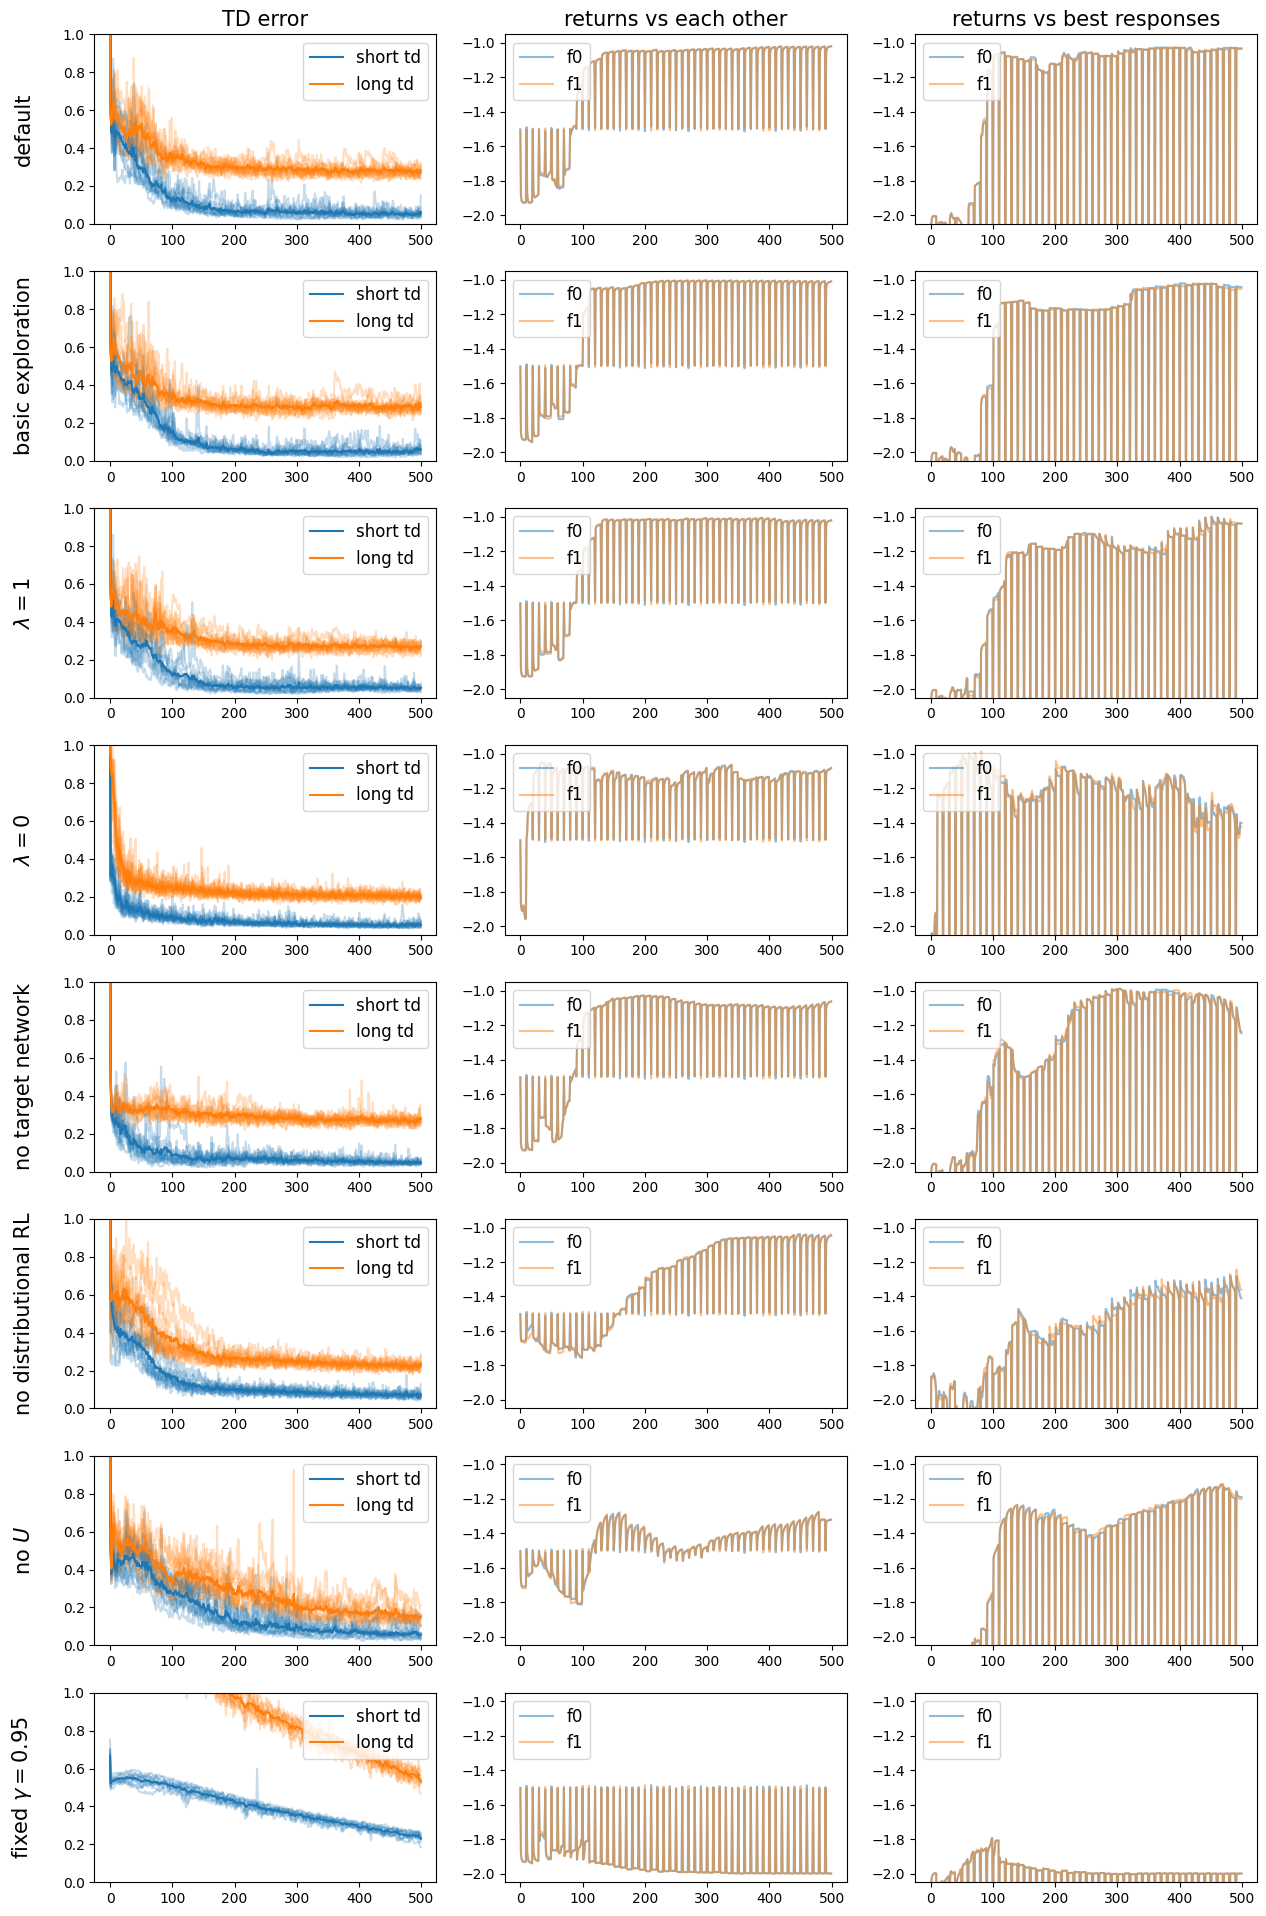

In [ ]:
def plot_ablation():
  variations = "default no_signs2 td1 td0 no_target no_qrl no_uhat fixed_gamma".split()
  fig, axes = plt.subplots(len(variations),3,squeeze=False, figsize=(5*3,3*len(variations)))# figsize=(15,6))
  for i, variation in enumerate(variations):
    final_errors = []
    seqss = []
    for run in Ablation.runs[variation]:
      seqs = deepmap(lambda *xs: jp.stack(xs), *run["log"])  # {k: [t]}
      seqss.append(seqs)
      final_errors.append(seqs["td"][-1])
      axes[i,0].plot(seqs["td"], alpha=0.25, color="tab:blue")
      axes[i,0].plot(seqs["longterm_td"], alpha=0.25, color="tab:orange")

    meanseq = deepmap(lambda *xs: sum(xs)/len(xs), *seqss)  # average across seeds
    #meanseq = deepmap(lambda xs: moving_avg(xs, 30, axis=0), meanseq)
    axes[i,0].plot(meanseq["td"], color="tab:blue", label="short td")
    axes[i,0].plot(meanseq["longterm_td"], color="tab:orange", label="long td")
    axes[i,1].plot(meanseq["o95_f"][:,0], color="tab:blue", label="f0", alpha=0.5)
    axes[i,1].plot(meanseq["o95_f"][:,1], color="tab:orange", label="f1", alpha=0.5)
    axes[i,2].plot(meanseq["o95_x"][:,0], color="tab:blue", label="f0", alpha=0.5)
    axes[i,2].plot(meanseq["o95_x"][:,1], color="tab:orange", label="f1", alpha=0.5)
    print(variation, np.mean(final_errors))
    title = dict(
      default="default\n",
      no_uhat="no $U$\n",
      no_signs2="basic exploration\n",
      no_target="no target network\n",
      td0="$\\lambda=0$\n",
      td1="$\\lambda=1$\n",
      no_qrl="no distributional RL\n",
      fixed_gamma="fixed $\\gamma=0.95$\n",
    ).get(variation,variation)
    #axes[i,0].set_title(title)
    axes[i,0].set_ylabel(title, fontsize=15)
    axes[i,0].set_ylim((0,1.0))
    axes[i,1].set_ylim((-2.05,-0.95))
    axes[i,2].set_ylim((-2.05,-0.95))
    axes[i,0].legend(fontsize=12, loc="upper right")
    axes[i,1].legend(fontsize=12, loc="upper left")
    axes[i,2].legend(fontsize=12, loc="upper left")
  axes[0,0].set_title("TD error", fontsize=15)
  axes[0,1].set_title("returns vs each other", fontsize=15)
  axes[0,2].set_title("returns vs best responses", fontsize=15)
  plt.subplots_adjust(hspace=0.25)
plot_ablation()

## Training MeVa for the tournament

Training a single model takes about 5-10 minutes depending on the opponent. Here we train on 3 games versus 3 different opponents, 10 seeds,
which takes about 10 hours.

training gameipd_mevaVnaive_seed100
100
  outer agent stats 95
    returns: [-1.0050595 -1.0050882]
    returns vs exploiters: [-0.9998533  -0.99989074]
    expected state (DD DC CD CC): [4.8324186e-03 2.4682865e-04 2.3719022e-04 9.9468303e-01]
200
  outer agent stats 95
    returns: [-1.8625768 -1.8611174]
    returns vs exploiters: [-0.7393352 -0.7360311]
    expected state (DD DC CD CC): [0.83182424 0.02978075 0.03026717 0.10812669]
300
  outer agent stats 95
    returns: [-1.871953  -1.8704472]
    returns vs exploiters: [-1.0124692  -0.79037297]
    expected state (DD DC CD CC): [0.8371384  0.03381129 0.03431324 0.09473629]
400
  outer agent stats 95
    returns: [-1.7069852 -1.8808687]
    returns vs exploiters: [-0.9008993 -2.0228534]
    expected state (DD DC CD CC): [0.7355927  0.08731512 0.02935414 0.14773744]
500
  outer agent stats 95
    returns: [-1.7349486 -1.8986714]
    returns vs exploiters: [-0.7304876 -2.020867 ]
    expected state (DD DC CD CC): [0.7524984  0.09159

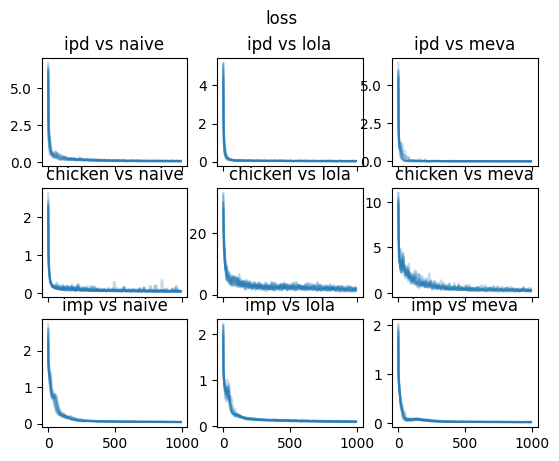

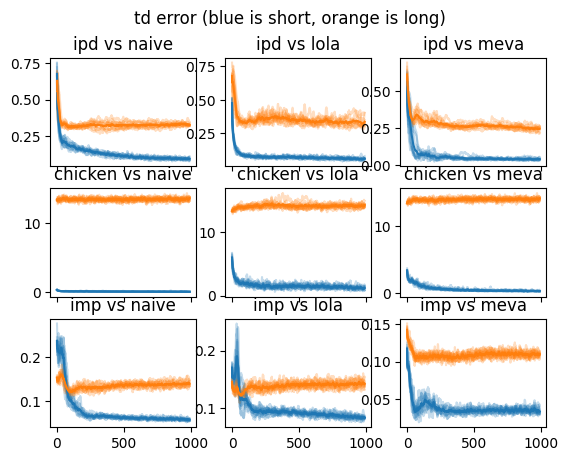

In [ ]:
ckpt_cache = CkptCache.make(f"{CACHE_ROOT}/matrix_20231116G")

class Meva: # just a namespace
  runs = dict()
  def _train(hp, runs=runs):
    hp = hp.replace(num_resblocks=0, outer_num_steps=1001)
    key = f"game{hp.game}_mevaV{hp.opponent}_seed{hp.seed}"
    run = ckpt_cache.load(key)
    if 0 or run is None:
      print("training", key)
      time_start = time.perf_counter()
      run = train_meva(hp)
      time_end = time.perf_counter()
      print("seconds taken: ", f"{time_end-time_start:.4f}")
      ckpt_cache.save(run, key)
    else:
      if run["hp"] != hp:
        print(key, "cached run has different hyperparameters")
        print("expected", run["hp"])
        print("got", hp)
        #raise RuntimeError("cached run has different hyperparameters")
    runs.setdefault(hp.game,dict()).setdefault(hp.opponent,[]).append(run)

  for game in "ipd chicken imp".split():
    for opponent in "naive lola meva".split():
      hp = Hp.make_for_game(game, opponent=opponent)
      for seed in range(10):
        _train(hp.replace(seed=seed+100))  # use previously unseen seeds

  fig, axes = plt.subplots(3,3, sharex=True)
  for i,game in enumerate(runs):
    for j,opponent in enumerate(runs[game]):
      for run in runs[game][opponent]:
        seqs = deepmap(lambda *xs: jp.stack(xs), *run["log"])
        seqs = deepmap(lambda xs: moving_avg(xs, 10, axis=0), seqs)
        axes[i,j].plot(seqs["loss"], alpha=0.25, color="tab:blue")
      axes[i,j].set_title(f"{game} vs {opponent}")
  fig.suptitle("loss")
  fig, axes = plt.subplots(3,3, sharex=True)
  for i,game in enumerate(runs):
    for j,opponent in enumerate(runs[game]):
      seqss = []
      for run in runs[game][opponent]:
        seqs = deepmap(lambda *xs: jp.stack(xs), *run["log"])
        seqs = deepmap(lambda xs: moving_avg(xs, 10, axis=0), seqs)
        seqss.append(seqs)
        axes[i,j].plot(seqs["td"], alpha=0.25, color="tab:blue")
        axes[i,j].plot(seqs["longterm_td"], alpha=0.25, color="tab:orange")
      meanseq = deepmap(lambda *xs: sum(xs)/len(xs), *seqss)
      #meanseq = deepmap(lambda xs: moving_avg(xs, 30, axis=0), meanseq)
      axes[i,j].plot(meanseq["td"], color="tab:blue", label="short td")
      axes[i,j].plot(meanseq["longterm_td"], color="tab:orange", label="long td")
      axes[i,j].set_title(f"{game} vs {opponent}")
  fig.suptitle("td error (blue is short, orange is long)")

## Train M-MAML/MetaMAPG for the tournament

M-MAML is pretty cheap to train, and we can afford to train many seeds at once, twice over to be able to play both sides. This cell takes about 10 minutes to run.

training gameipd_maml_seed100
seconds taken:  181.4295
training gamechicken_maml_seed100
seconds taken:  181.9689
training gameimp_maml_seed100
seconds taken:  180.8148


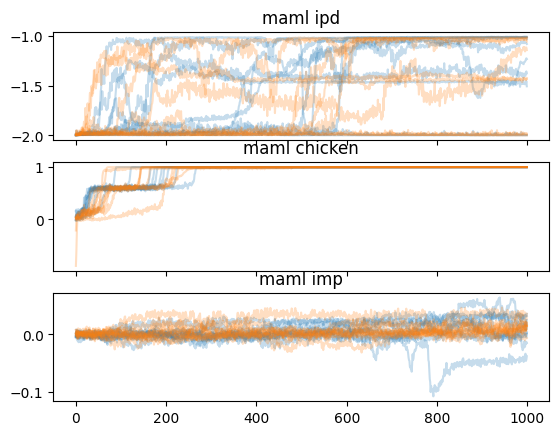

In [ ]:
def train_maml(hp):
  game = hp.get_game()

  @jax.jit
  @partial(jax.vmap, in_axes=(0,0,0))  # across seeds
  def _train_step(m, optimizer, rng):
    T=hp.inner_num_steps;B=hp.inner_batch_size
    @jax.vmap  # across two players
    def V(m,i):
      xa,mlr = m
      lrs = jp.stack([mlr,hp.alpha])
      xb = init_agents(rng, [B])[:,0]
      @jax.vmap  # across batch of opponent initializations
      def batchV(xb):
        f = permute_game(game,i)
        x = jp.stack([xa,xb])
        def body_fn(x,_):
          x = x+lrs[:,None]*naive_gradients(f)(x)
          return x,x
        _,xs = jax.lax.scan(body_fn, x, None, length=T)
        ys = jax.vmap(f)(xs)
        return ys[:,0].mean(axis=0)
      return batchV(xb).mean(axis=0)
    def pairV(m,i):
      v = V(m,i)
      return v.sum(), v
    (_,v), dm = jax.value_and_grad(pairV,has_aux=True)(m,jp.arange(2))
    optimizer, dm = optimizer(m,dm)
    m = deepmap(lambda m,dm:m+dm, m,dm)
    return v, m, optimizer

  S = hp.outer_batch_size
  rng = rax.PRNGKey(hp.seed)
  # train a pair of mamls, one learns to play rows, the other columns
  mx0 = init_agents(rscope(rng,"init"), [S])  # [S,2,5]
  mlr = hp.alpha*jp.ones([S,2],dtype="float32")  # [S,2]
  maml = [mx0,mlr]
  optimizer = jax.vmap(lambda m: AdamOptimizer.make_for(m, lr=0.1))(maml)
  log = []
  for step in range(hp.outer_num_steps):
    v, maml, optimizer = _train_step(maml, optimizer, rax.split(rscope(rng,step), S))
    assert maml[0].shape == (S,2,5)
    log.append(dict(v=v))
  [maml0,maml1] = deepunstack(maml,axis=1)
  return dict(mamls=[maml0,maml1], log=log)

@struct.dataclass
class MamlHp:
  game: str = "ipd"
  game_discount: float = 0.96
  outer_num_steps: int = 1000
  inner_num_steps: int = 300
  outer_batch_size: int = 10  # number of maml learners to produce
  inner_batch_size: int = 64  # number of inner loop trajectories
  seed: int = 100

  def get_game(self):
    return Game(discount=self.game_discount, payoffs=PAYOFF_MATRICES[self.game])

  @property
  def alpha(self):
    return dict(ipd=1,chicken=1,imp=0.1)[self.game]/(1-self.game_discount)

class Maml:  # just a namespace
  runs = dict()
  def train(hp, runs=runs):
    key = f"game{hp.game}_maml_seed{hp.seed}"
    run = ckpt_cache.load(key)
    if 0 or run is None:
      print("training", key)
      time_start = time.perf_counter()
      run = train_maml(hp)
      time_end = time.perf_counter()
      print("seconds taken: ", f"{time_end-time_start:.4f}")
      ckpt_cache.save(run, key)
    runs[hp.game] = run

  for game in "ipd chicken imp".split():
    hp = MamlHp(game=game)
    train(hp)

  fig, axes = plt.subplots(3,1,squeeze=False,sharex=True)
  for i,(game,run) in enumerate(runs.items()):
    seqs = deepmap(lambda *xs: jp.stack(xs), *run["log"])
    #seqs = deepmap(lambda xs: moving_avg(xs, 10, axis=0), seqs)
    axes[i,0].plot(seqs["v"][...,0], alpha=0.25, color="tab:blue")
    axes[i,0].plot(seqs["v"][...,1], alpha=0.25, color="tab:orange")
    axes[i,0].set_title(f"maml {game}")

# Analysis

The rest of this colab takes only a few minutes to run.

## Tournament

In [ ]:
@struct.dataclass
class NaiveLearner:
  game: "Game"; lr: "float"; identity: "int"
  def __call__(self,a,b):
    game = permute_game(self.game,self.identity)
    def f(a):
      return game(jp.stack([a,b]))[0]
    da = jax.grad(f)(a)
    return a+self.lr*da
@struct.dataclass
class LolaLearner:
  game: "Game"; lr: "float"; alpha: "float"; identity: "int"
  def __call__(self,a,b):
    f_lola = partial(make_f_lola(self.game),alpha=self.alpha)
    f_lola = permute_game(f_lola,self.identity)
    def f(a):
      return f_lola(jp.stack([a,b]))[0]
    da = jax.grad(f)(a)
    return a+self.lr*da
@struct.dataclass
class MevaLearner:
  game: "Game"; vhat: "vhat"; lr: "float"; gammas: "float[2]"; identity: "int"
  def __call__(self,a,b):
    hp = self.vhat.module.hp
    gammas = self.gammas[((self.identity,1-self.identity),)]
    def V(x):
      if hp.correction_version:
        y = self.game(x)
        u = self.vhat(x,gamma=gammas)
        v = (1-gammas)*y+gammas*u
      else:
        v = self.vhat(x,gamma=gammas)
      return v
    V = permute_game(V,self.identity)
    def f(a):
      return V(jp.stack([a,b]))[0]
    da = jax.grad(f)(a)
    return a+self.lr*da
@struct.dataclass
class MamlLearner:
  game: "Game"; lr: "lr"; x0: "x0"; identity: "int"
  def __call__(self,a,b):
    game = permute_game(self.game,self.identity)
    def f(a):
      return game(jp.stack([a,b]))[0]
    da = jax.grad(f)(a)
    return a+self.lr*da

def train_learners(x, learners, T=100):
  assert x.shape == (2,5); assert len(learners) == 2
  def body_fn(x,_):
    x = jp.stack([l(x[i],x[1-i]) for i,l in enumerate(learners)])
    return x,x
  x,xs = jax.lax.scan(body_fn, x, None, length=T)
  return x,xs
@partial(jax.jit, static_argnames="B T".split())
def train_learners_batch(learners, rng=None, x=None, B=128, T=100):
  if x is None:
    x = init_agents(rng, [B])
  x,trail = jax.vmap(lambda x: train_learners(x, learners, T=T))(x)
  return x,trail  # [B,2,5],[B,T,2,5]

In [ ]:
#%%script echo skipping
def tournament(num_trials=1024):
  gammastr = "95"; gamma = int(gammastr)/100  # evaluate at fixed vhat gamma

  tables = dict()
  for game in Meva.runs:
    print("### ipd")
    hp = Meva.runs[game]["meva"][0]["hp"]
    f = hp.get_game()
    alpha = hp.alpha

    def make_learner(key,opponent,identity):
      if key == "naive": return [NaiveLearner(game=f, lr=alpha, identity=identity)]
      if key == "lola":  return [LolaLearner(game=f, lr=alpha, alpha=alpha, identity=identity)]
      if key == "maml":  return [
          MamlLearner(game=f, lr=mlr, x0=mx0, identity=identity)
          for mx0,mlr in deepunstack(Maml.runs[game]["mamls"][identity])
        ]
      if key == "meva":
        if identity==1: assert opponent == "meva"  # meva only trained as player 0 against others
        return [
          MevaLearner(game=f, lr=alpha, vhat=run["vhat"], gammas=jp.full([2],gamma), identity=identity)
          for run in Meva.runs[game]["naive" if opponent == "maml" else opponent]
        ]
      raise KeyError(key)
    def do_match(key1,key2,N=num_trials):
      learners1 = make_learner(key1,key2,identity=0)
      learners2 = make_learner(key2,key1,identity=1)
      S1,S2 = len(learners1),len(learners2)
      K = int(np.ceil(N/(S1*S2)))  # number of times we need to test each pair of seeds to get N trials
      print("  matching", f"{key1}[{S1}]×{key2}[{S2}]", "batch size", K, "excess", (S1*S2*K)-N)
      xs = []
      for i,(l1,l2) in enumerate(itertools.product(learners1,learners2)):
        x0 = init_agents(rax.PRNGKey(200+i), [K])
        if key1 == "maml": x0 = x0.at[:,0].set(l1.x0)
        if key2 == "maml": x0 = x0.at[:,1].set(l2.x0)
        x,_ = train_learners_batch([l1,l2], x=x0, B=K, T=300)
        xs.append(x)
      # stack on axis 1 to order elements such that [:N] covers all seed pairs
      x = jp.stack(xs,axis=1) # [K,S1*S2,2,5]
      x = x.reshape([K*S1*S2,2,5])[:N]
      return x

    candidates = "naive lola maml meva".split()
    table = [["" for _ in candidates] for _ in candidates]
    def record(keys,mu,sem):
      i,j=candidates.index(keys[0]),candidates.index(keys[1])
      table[i][j]=(mu[0],sem[0]); table[j][i]=(mu[1],sem[1])
    for key1,key2 in itertools.combinations_with_replacement(candidates,2):
      if key2=="meva":
        # meva must play as player 0 to avoid having to train twice as many models.
        # all games are symmetric... except imp.
        key1,key2=key2,key1
      x = do_match(key1,key2)
      y = f.vmap(x)
      mu = y.mean(axis=0); sem = y.std(axis=0)/y.shape[0]**0.5
      record([key1,key2],mu,sem)

    # expand table to include mfos results, computed externally
    mfosrow = dict(ipd=dict(naive=(-0.56,0.0309),lola=(-1.0243,0.0002)),
                   imp=dict(naive=(0.1963,0.0007),lola=(0.1887,0.0007)),
                   chicken=dict(naive=(0.9698,0.0003),lola=(-1.1578,0.1155)),
    )[game]
    mfoscol = dict(ipd=dict(naive=(-2.0232,0.0558),lola=(-1.0228,0.0003)),
                   imp=dict(naive=(-0.1963,0.0007),lola=(-0.1887,0.0007)),
                   chicken=dict(naive=(-1.0269,0.0003),lola=(0.7942,0.1178)),
    )[game]
    mfoscell = dict(ipd=(-1.0056,0.0002), imp=(0,0.0119), chicken=(-0.0068,0.1289))[game]
    for i,candidate in enumerate(candidates):
      table[i].insert(-1, mfoscol.get(candidate, None))
    table.insert(-1, [mfosrow.get(candidate, None) for candidate in candidates])
    table[-2].insert(-1, mfoscell)
    candidates.insert(-1, "mfos")

    tables[game] = (candidates,table)
  return tables

class Tournament:
  tables = tournament()

  matching naive[1]×naive[1] batch size 1024 excess 0
  matching naive[1]×lola[1] batch size 1024 excess 0
  matching naive[1]×maml[10] batch size 103 excess 6
  matching meva[10]×naive[1] batch size 103 excess 6
  matching lola[1]×lola[1] batch size 1024 excess 0
  matching lola[1]×maml[10] batch size 103 excess 6
  matching meva[10]×lola[1] batch size 103 excess 6
  matching maml[10]×maml[10] batch size 11 excess 76
  matching meva[10]×maml[10] batch size 11 excess 76
  matching meva[10]×meva[10] batch size 11 excess 76
  matching naive[1]×naive[1] batch size 1024 excess 0
  matching naive[1]×lola[1] batch size 1024 excess 0
  matching naive[1]×maml[10] batch size 103 excess 6
  matching meva[10]×naive[1] batch size 103 excess 6
  matching lola[1]×lola[1] batch size 1024 excess 0
  matching lola[1]×maml[10] batch size 103 excess 6
  matching meva[10]×lola[1] batch size 103 excess 6
  matching maml[10]×maml[10] batch size 11 excess 76
  matching meva[10]×maml[10] batch size 11 excess 

In [ ]:
def print_tables(tables):
  for game,(labels,table) in tables.items():
    print("###",game)
    def format_cell(cell):
      if cell is None: return ""
      mu,sem = cell
      return f"{mu:+.3f}~{sem:.3f}"
    print(tabulate.tabulate([[label, *map(format_cell,row)]
                              for label,row in eqzip(labels,table)],
                            headers=labels))
print_tables(Tournament.tables)

### ipd
       naive         lola          maml          mfos          meva
-----  ------------  ------------  ------------  ------------  ------------
naive  -1.988~0.003  -1.377~0.015  -1.524~0.017  -2.023~0.056  -1.999~0.004
lola   -1.357~0.014  -1.041~0.005  -0.974~0.005  -1.023~0.000  -1.032~0.001
maml   -1.398~0.015  -1.290~0.010  -1.224~0.012                -1.993~0.004
mfos   -0.560~0.031  -1.024~0.000                -1.006~0.000
meva   -0.551~0.002  -1.145~0.003  -0.534~0.002                -1.052~0.003
### chicken
       naive         lola          maml          mfos          meva
-----  ------------  ------------  ------------  ------------  ------------
naive  -0.049~0.023  -0.402~0.017  -0.994~0.005  -1.027~0.000  -0.985~0.002
lola   +0.377~0.017  -1.641~0.369  -0.805~0.017  +0.794~0.118  +0.138~0.020
maml   +0.983~0.005  +0.778~0.018  -0.447~0.041                -0.908~0.038
mfos   +0.970~0.000  -1.158~0.116                -0.007~0.129
meva   +0.964~0.003  -0.232~0.021  +

In [ ]:
def print_tabulars(tables):
  def format_cell(cell):
    if cell is None: return ""
    mu,sem = cell
    return f"{mu:.2f}\\ERR{{{sem:.2f}}}"
  for game,(labels,table) in tables.items():
    labels = [dict(naive="Naive",lola="LOLA",maml="M-MAML",meva="MeVa",mfos="M-FOS")[l] for l in labels]
    print(r"\newcommand{\%stabular}{"%game)
    print(r"""\begin{tabular}[t]{l|%s}
              \rule{0pt}{1.1em}
              & %s \\
              \hline \rule{0pt}{1.1em}%%""" % ("r"*len(labels)," & ".join(labels)))
    for label,row in eqzip(labels,table):
      print(" & ".join([label,*map(format_cell,row)]), r"\\")
    print(r"\end{tabular}}")
print_tabulars(Tournament.tables)

\newcommand{\ipdtabular}{
\begin{tabular}[t]{l|rrrrr}
              \rule{0pt}{1.1em}
              & Naive & LOLA & M-MAML & M-FOS & MeVa \\
              \hline \rule{0pt}{1.1em}%
Naive & -1.99\ERR{0.00} & -1.38\ERR{0.01} & -1.52\ERR{0.02} & -2.02\ERR{0.06} & -2.00\ERR{0.00} \\
LOLA & -1.36\ERR{0.01} & -1.04\ERR{0.00} & -0.97\ERR{0.01} & -1.02\ERR{0.00} & -1.03\ERR{0.00} \\
M-MAML & -1.40\ERR{0.01} & -1.29\ERR{0.01} & -1.22\ERR{0.01} &  & -1.99\ERR{0.00} \\
M-FOS & -0.56\ERR{0.03} & -1.02\ERR{0.00} &  & -1.01\ERR{0.00} &  \\
MeVa & -0.55\ERR{0.00} & -1.15\ERR{0.00} & -0.53\ERR{0.00} &  & -1.05\ERR{0.00} \\
\end{tabular}}
\newcommand{\chickentabular}{
\begin{tabular}[t]{l|rrrrr}
              \rule{0pt}{1.1em}
              & Naive & LOLA & M-MAML & M-FOS & MeVa \\
              \hline \rule{0pt}{1.1em}%
Naive & -0.05\ERR{0.02} & -0.40\ERR{0.02} & -0.99\ERR{0.00} & -1.03\ERR{0.00} & -0.98\ERR{0.00} \\
LOLA & 0.38\ERR{0.02} & -1.64\ERR{0.37} & -0.80\ERR{0.02} & 0.79\ERR{0.12} & 0.14\ER

## ZD extortion

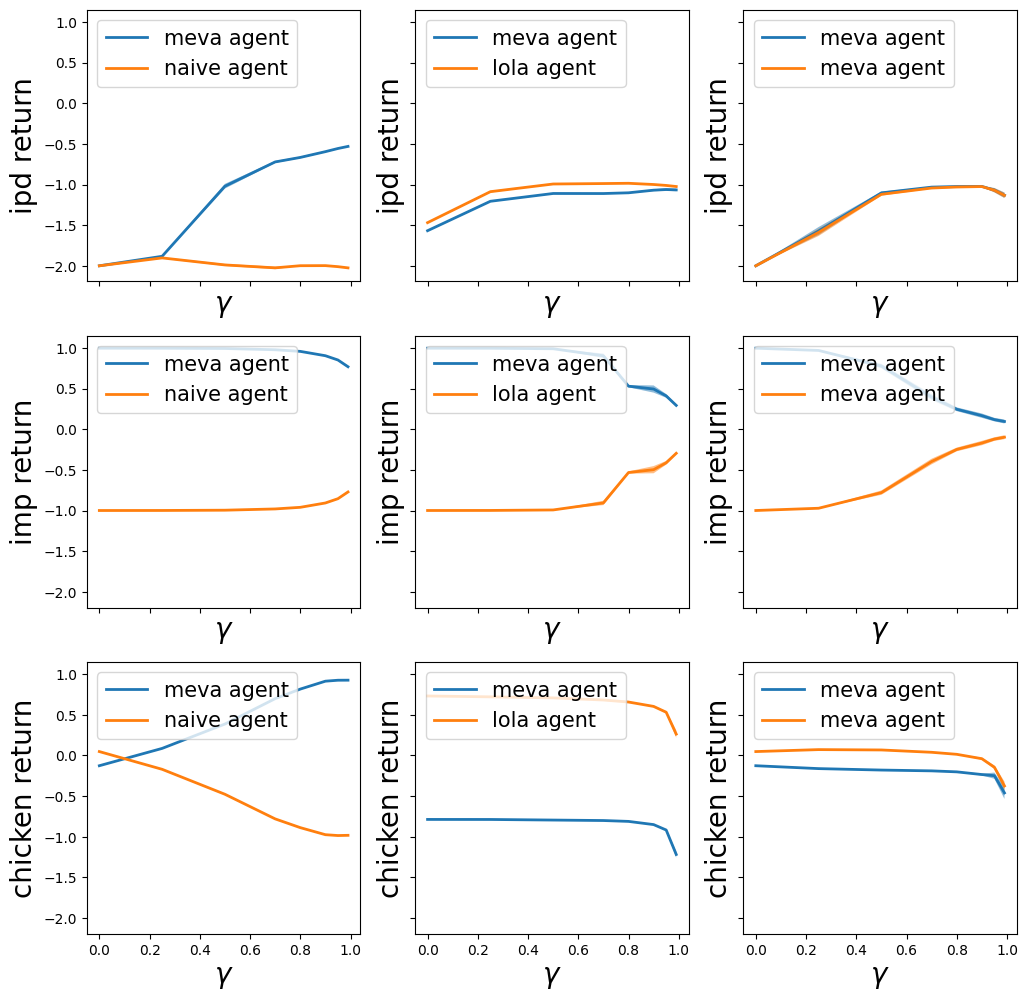

In [ ]:
if 0 or "_train_meva" not in globals():
  @functools.cache
  def _train_meva(game, opponent, gammastr):
    gamma = int(gammastr)/100
    trails = []
    for run in Meva.runs[game][opponent]:
      game = run["hp"].get_game()
      vhat = run["vhat"]
      learners_table = dict(
          naive=NaiveLearner(game=game, lr=run["hp"].alpha),
          lola=LolaLearner(game=game, lr=run["hp"].alpha, alpha=run["hp"].alpha),
          meva=MevaLearner(game=game, lr=run["hp"].alpha, vhat=vhat, gammas=jp.full([2],gamma)),
      )
      learners = [learners_table["meva"],learners_table[opponent]]
      _,trail = train_learners_batch(learners, rng=rax.PRNGKey(1), B=128)
      trails.append(trail)
    return jp.stack(trails) # [seed,B,T,2,5]
def plot_f_over_gamma(ax, game, opponent, ylabel=False):
  gammastrs = "00 25 50 70 80 90 95 99".split()
  gammas = [int(gammastr)/100 for gammastr in gammastrs]
  xs = []
  for gammastr, gamma in eqzip(gammastrs, gammas):
    x = _train_meva(game, opponent, gammastr)[:,:,-1]  # [S,B,2,5]
    xs.append(x)
  xs = jp.stack(xs) # [gamma,S,B,2,5]
  [G,S,B,_,_] = xs.shape
  f = Meva.runs[game][opponent][0]["hp"].get_game()  # FIXME sadge
  ys = jax.vmap(jax.vmap(jax.vmap(f)))(xs)
  assert ys.shape == (G,S,B,2)

  ys = ys.mean(axis=2) # average across batch
  # compute mean/sem across seed
  mu = ys.mean(axis=1); sem = ys.std(axis=1)/S**0.5
  qs = np.stack([mu-sem, mu, mu+sem])
  ax.plot(gammas, qs[1], linewidth=2)
  for i in range(2):
    ax.fill_between(gammas, qs[0,:,i], qs[2,:,i], alpha=0.5)
  ax.set_xlabel("$\\gamma$", fontsize=20)
  if ylabel: ax.set_ylabel(f"{game} return", fontsize=20)
  #ax.set_ylim((-2,-1)); ax.set_xlim((0,1))
  ax.legend(["meva agent", f"{opponent} agent"], fontsize=15, loc="upper left")

fig, axes = plt.subplots(3,3,sharex=True, sharey=True, figsize=(12,12), squeeze=False)
for i,game in enumerate("ipd imp chicken".split()):
  for j,opponent in enumerate("naive lola meva".split()):
    plot_f_over_gamma(axes[i,j], game, opponent, ylabel=True)

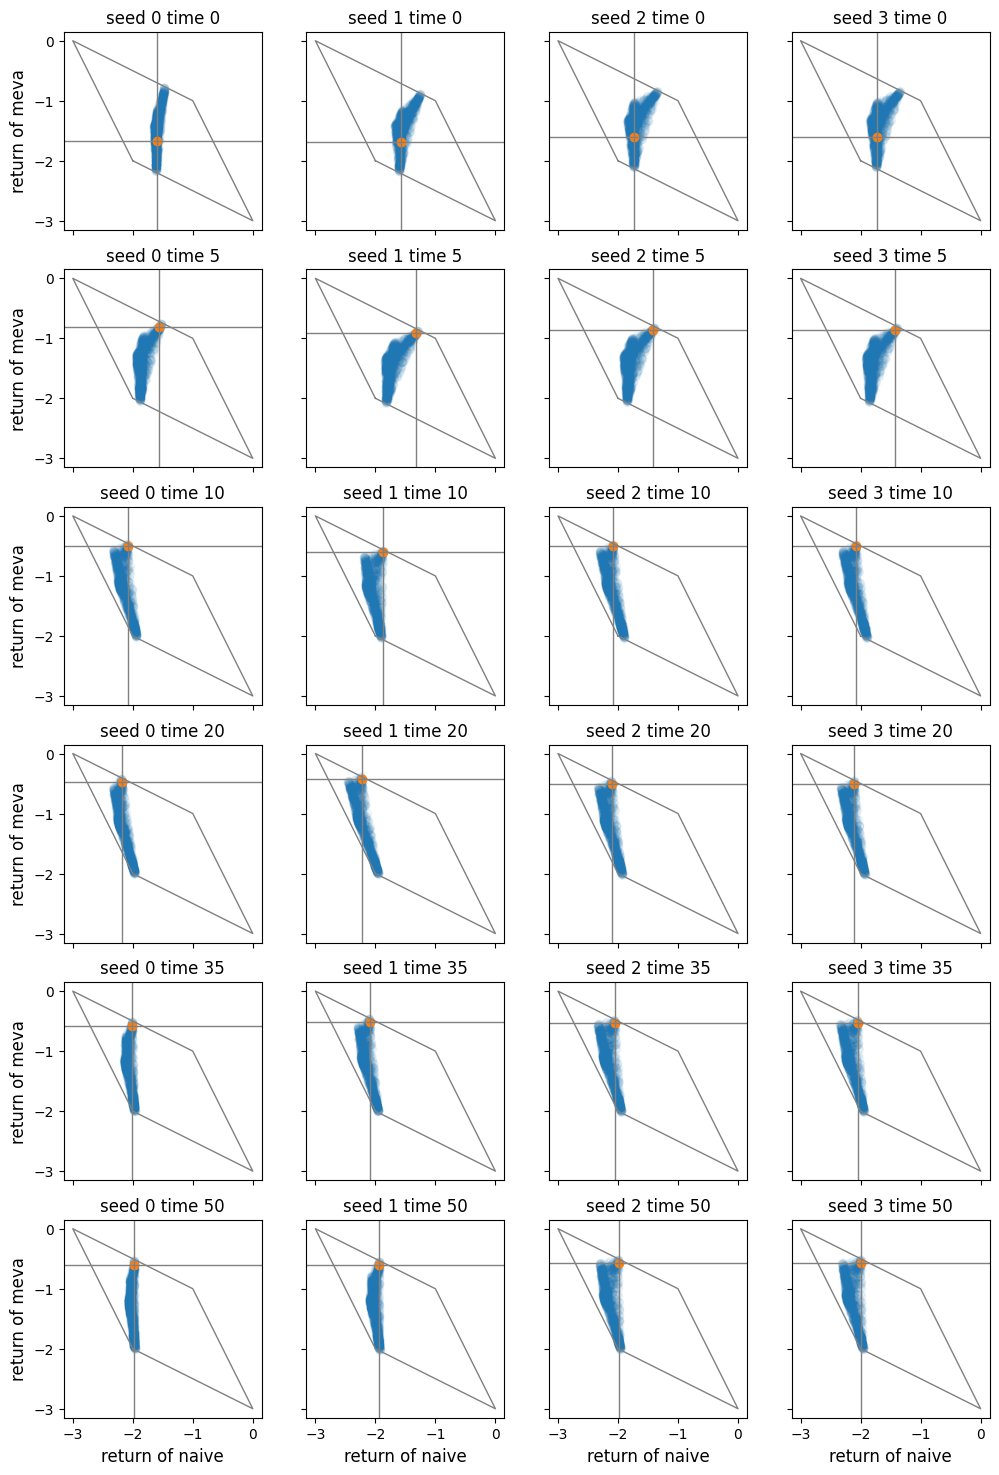

In [ ]:
#%%script echo skipping

# plot payoff polytopes to show ZD-ness
def plot_polytope(ax, game, x):
  potential = (jax.vmap(lambda opponent: game(jp.stack([x[0], opponent])))
               (-5 + 10*rax.uniform(rax.PRNGKey(1), shape=[1000,5])))
  actual = game(x)
  ax.axhline(actual[0], c="gray", linewidth=1)
  ax.axvline(actual[1], c="gray", linewidth=1)
  ## plot general payoff polytope
  # need to reorder payoffs to get a nice cycle
  ax.plot(game.payoffs[(0,1,3,2,0),1], game.payoffs[(0,1,3,2,0),0], color="gray", linewidth=1)
  #ax.set_xlim((-3,0)); ax.set_ylim((-3,0))
  ax.set_aspect("equal")
  ## plot payoff range for any value of x[1], conditioned on x[0]
  ax.scatter(potential[:,1], potential[:,0], c="tab:blue", alpha=0.05)
  ## plot actual agents[1] payoff
  ax.scatter(actual[1], actual[0], c="tab:orange")
  ax.set_xticks([-3,-2,-1,0])
  ax.set_yticks([-3,-2,-1,0])

# prepare a figure for publication
def plot_polytopes(gammastr="95"):
  game = "ipd"; opponent = "naive"
  gamma = int(gammastr)/100
  trail = _train_meva(game, opponent, gammastr)  # [S,B,T,2,5]
  [S,B,T,_,_] = trail.shape
  f = Game.make(game)
  fig, axes = plt.subplots(6,4,sharex=True,sharey=True,figsize=(12,18))
  for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
      t = [0,5,10,20,35,50][i]
      plot_polytope(axes[i,j], f, trail[j,1,t])
      if j == 0:
        axes[i,j].set_ylabel("return of meva", fontsize=12)
      if i == axes.shape[0]-1:
        axes[i,j].set_xlabel(f"return of {opponent}", fontsize=12)
      axes[i,j].set_title(f"seed {j} time {t}")
plot_polytopes()